In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                -1.296334e+01
p-value                        3.191205e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


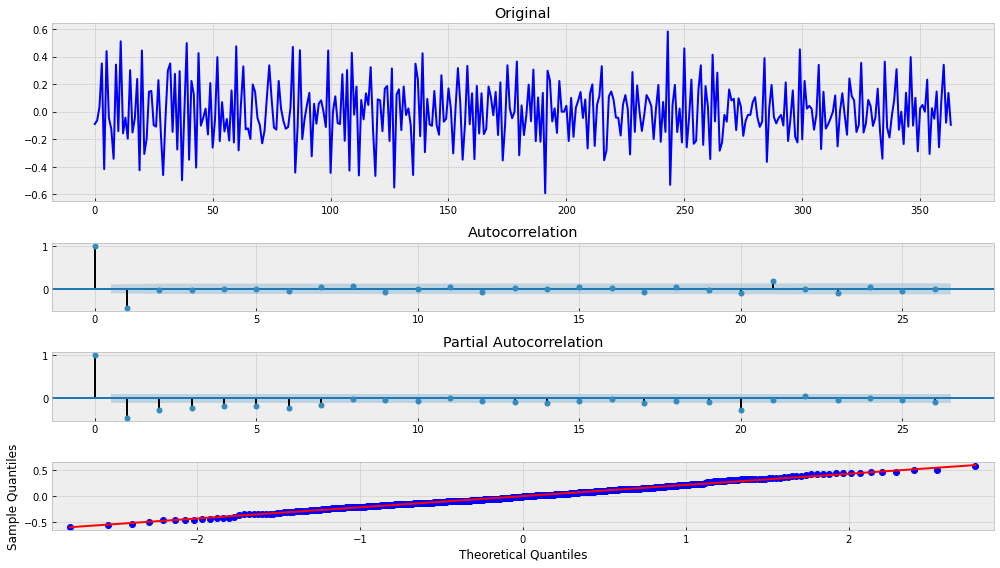

In [114]:
df = pd.read_csv('./Архив/Series/daily-total-female-births-in-cal.csv')
series = df['Count']
series = boxcox(series, 0)
series = series[1:] - series[:-1]
tsplot(series)

In [115]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: -266.66796 | order: (2, 0, 4)


Results of Dickey-Fuller Test:
Test Statistic                 -19.081451
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    363.000000
Critical Value (1%)             -3.448494
Critical Value (5%)             -2.869535
Critical Value (10%)            -2.571029
dtype: float64


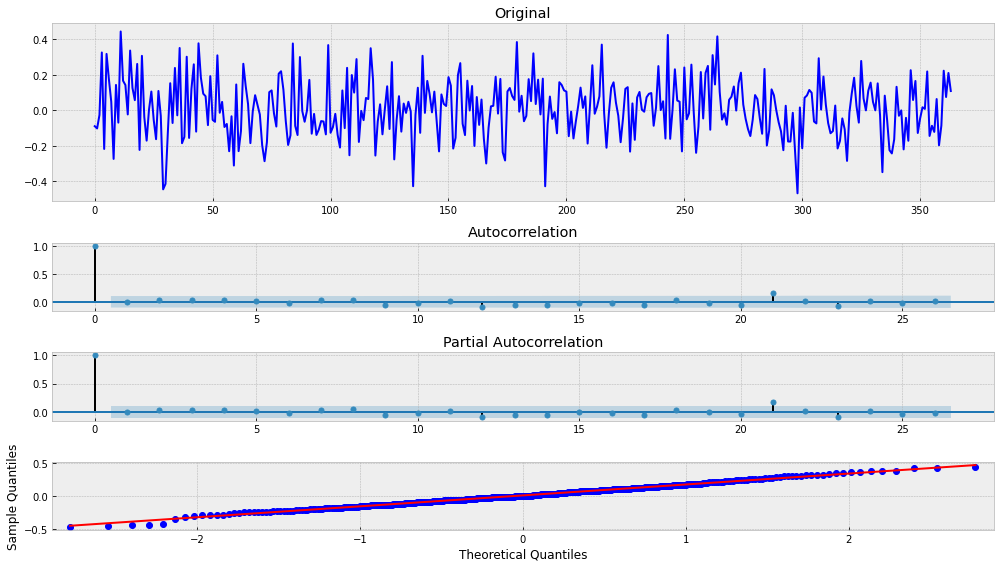

In [116]:
tsplot(mdl.resid)

In [117]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                45.5355
Distribution:      Standardized Student's t   AIC:                          -73.0710
Method:                  Maximum Likelihood   BIC:                          -37.9966
                                              No. Observations:                  364
Date:                      Sat, May 09 2020   Df Residuals:                      355
Time:                              21:31:14   Df Model:                            9
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                -1.296334e+01
p-value                        3.191205e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


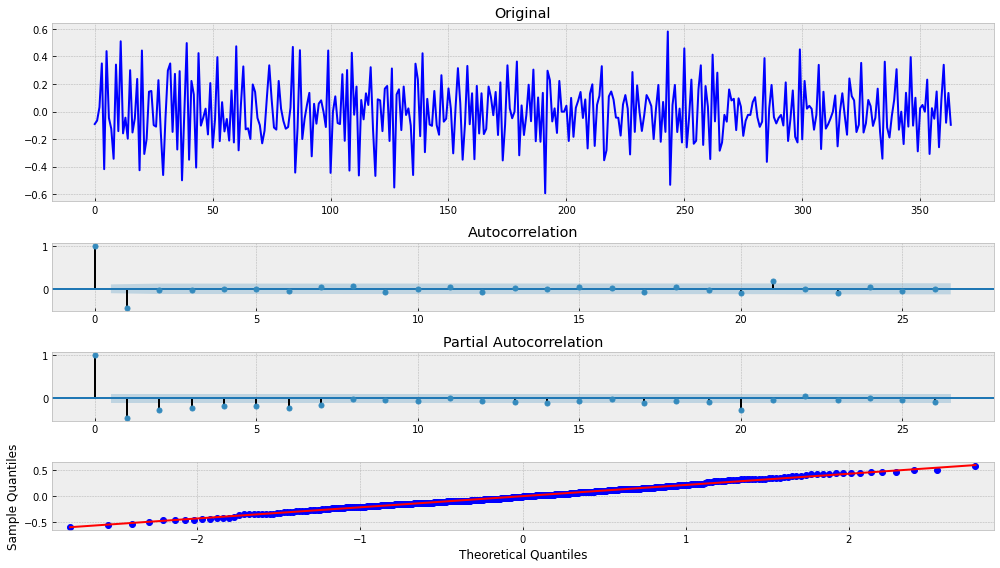

In [118]:
tsplot(res.resid)

### Классический ML

В основе предобработка из лекции + среднее по последним n наблюдениям.

In [119]:
def last_n_mean(data, n):
    k = 0
    for i in range(n):
        k += data['lag_{}'.format(i+1)]
    return k/n

In [146]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    for i in range(lag_end-1):
        data['last_{}_mean'.format(i+1)] = \
            data.apply(lambda x: last_n_mean(data, i+1)).iloc[:,0]
    data = data.reset_index(drop=True)
    data = data.drop(["Date"], axis=1)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [147]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=20, test_size=0.3)

И попробуем несколько стандартных алгоритмов со стандартными гиперпараметрами.

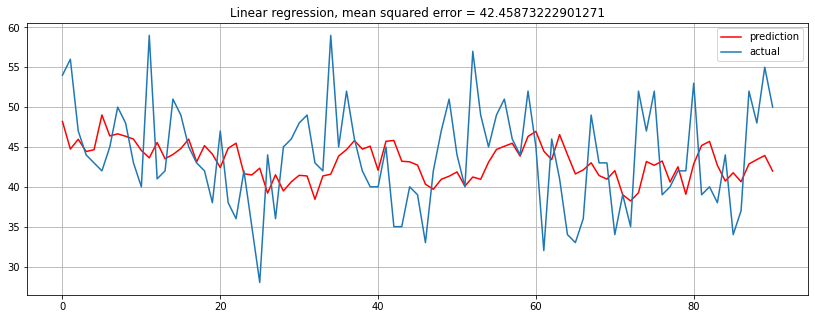

In [169]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title('Linear regression, mean squared error = {}'.format(mean_squared_error(y_test, prediction)))
plt.grid(True);

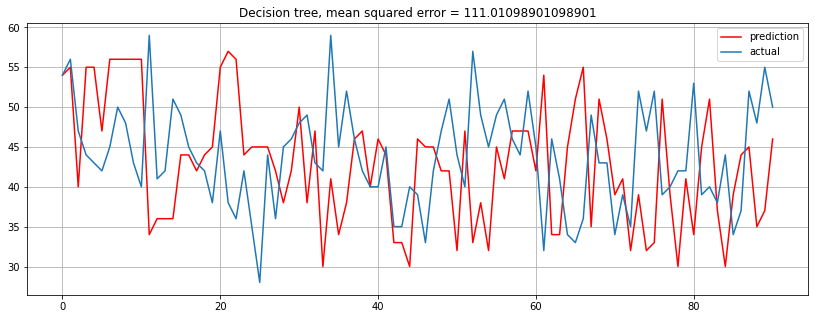

In [170]:
tr = DecisionTreeRegressor()
tr.fit(X_train, y_train)
prediction = tr.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title('Decision tree, mean squared error = {}'.format(mean_squared_error(y_test, prediction)))
plt.grid(True);

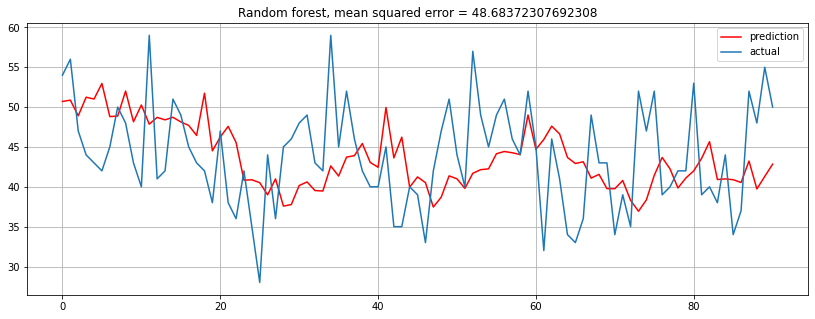

In [171]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)

plt.figure(figsize=(14, 5))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title('Random forest, mean squared error = {}'.format(mean_squared_error(y_test, prediction)))
plt.grid(True)